In [3]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

import random
import numpy as np
import tensorflow as tf

In [56]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)
TTree = process_ntuple(dir_path, files[0])
files

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root',
 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']

$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [5]:
DMesons_df = show(0, TTree, ["DMesons_pt","DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId"], 20000000)
DMesons_df = remove_empty(DMesons_df)

DMesons_df["DMesons_pt"] = DMesons_df["DMesons_pt"].apply(divide_by_1000)
for col in DMesons_df.columns:
    DMesons_df[col] = DMesons_df[col].apply(list)
    
DMesons_df = apply_cuts(DMesons_df)
pd.set_option('display.max_rows', 10)
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122]
...,...,...,...,...,...,...
8235046,[17.96],[-0.6264557838439941],[1865.6043701171875],[5.87862491607666],[0.45278045535087585],[411]
8235047,"[62.91061328125, 62.91061328125]","[0.2775037884712219, 0.2775037884712219]","[1847.262451171875, 2131.1259765625]","[11.870012283325195, 11.870012283325195]","[-0.9544855356216431, -0.9355815052986145]","[411, 4122]"
8235048,"[14.8181767578125, 14.8181767578125]","[-2.1479332447052, -2.1479332447052]","[1836.0997314453125, 2165.72412109375]","[2.027026653289795, 2.027026653289795]","[-0.9712575674057007, -0.9517184495925903]","[411, 4122]"
8235049,[39.3814296875],[1.5503557920455933],[2210.86669921875],[0.17065481841564178],[-0.332907497882843],[4122]


In [60]:
#save to disk
with open('DMesons_df.pickle', 'wb') as f:
    pickle.dump(DMesons_df, f)


In [61]:
#open
with open('DMesons_df.pickle', 'rb') as f:
    DMesons_df = pickle.load(f)


In [58]:
DMesons_df2 = show(0, TTree, ["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId"], 100)
DMesons_df2 = remove_empty(DMesons_df2)

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df2.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")
                    
len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

#for now just remove the rows
indices = [i for i, x in enumerate(DMesons_df2[DMesons_df2.columns[0]]) if len(x) > 2]
DMesons_df2 = DMesons_df2.drop(indices)
DMesons_df2 = DMesons_df2.reset_index(drop=True)
DMesons_df2["DMesons_daughterInfo__pt"] = DMesons_df2["DMesons_daughterInfo__pt"].apply(divide_by_1000)
DMesons_df2

pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_columns', None)

# print("-----------------")
# print(DMesons_df.iloc[32, 0][2])
# print(DMesons_df.iloc[32, 1][2])
# print(DMesons_df.iloc[32, 2][2])
# print(DMesons_df.iloc[32, 3][2])

In [21]:
# create a new column 'particle_type' based on the pdgId column
func = lambda x: 'only_411' if x == [411] else ('only_4122' if x == [4122] else 'both')
DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
both = DMesons_df[DMesons_df['particle_type'] == 'both']

new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
new_df = new_df.reset_index(drop=True)

new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_m'] = new_df['DMesons_m'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_fitOutput__Lxy'] = new_df['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_costhetastar'] = new_df['DMesons_costhetastar'].apply(lambda x: float(x[0]))
new_df.loc[:, 'DMesons_pdgId'] = new_df['DMesons_pdgId'].apply(lambda x: int(x[0]))
new_df = new_df.drop('particle_type', axis=1)
new_df

/tmp/ipykernel_36828/2689228095.py:13: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.loc[:, 'DMesons_pt'] = new_df['DMesons_pt'].apply(lambda x: float(x[0]))
/tmp/ipykernel_36828/2689228095.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.loc[:, 'DMesons_eta'] = new_df['DMesons_eta'].apply(lambda x: float(x[0]))
/tmp/ipykernel_36828/2689228095.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, us

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,0.081824,1862.417603,2.339530,0.254870,411
1,36.128836,0.659816,2235.698730,0.358412,0.190362,4122
2,14.835231,-0.928085,1867.131470,2.899070,0.684572,411
3,8.800141,-1.486876,2174.800781,0.246351,-0.737246,4122
4,30.092365,0.434246,2306.049072,7.426617,-0.937342,4122
...,...,...,...,...,...,...
2515990,24.477744,-0.272090,1882.772461,3.593372,0.539289,411
2515991,14.971446,-1.956944,1835.712280,2.374407,0.863583,411
2515992,12.734207,-0.039695,1867.319092,5.151422,0.461929,411
2515993,17.960000,-0.626456,1865.604370,5.878625,0.452780,411


In [22]:
D = 0
Lambda = 0
for pdgId in new_df["DMesons_pdgId"]:
    if pdgId == 411:
        D+=1
    elif pdgId == 4122:
        Lambda+=1
print(D, Lambda)

1566666 949329


In [23]:
only_411 = only_411.reset_index(drop=True)
only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_eta'] = only_411['DMesons_eta'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_m'] = only_411['DMesons_m'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_fitOutput__Lxy'] = only_411['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_costhetastar'] = only_411['DMesons_costhetastar'].apply(lambda x: float(x[0]))
only_411.loc[:, 'DMesons_pdgId'] = only_411['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_411 = only_411.drop('particle_type', axis=1)

only_4122 = only_4122.reset_index(drop=True)
only_4122.loc[:, 'DMesons_pt'] = only_4122['DMesons_pt'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_eta'] = only_4122['DMesons_eta'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_m'] = only_4122['DMesons_m'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_fitOutput__Lxy'] = only_4122['DMesons_fitOutput__Lxy'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_costhetastar'] = only_4122['DMesons_costhetastar'].apply(lambda x: float(x[0]))
only_4122.loc[:, 'DMesons_pdgId'] = only_4122['DMesons_pdgId'].apply(lambda x: int(x[0]))
only_4122 = only_4122.drop('particle_type', axis=1)

new_df = new_df.drop('DMesons_m', axis=1)
only_411 = only_411.drop('DMesons_m', axis=1)
only_4122 = only_4122.drop('DMesons_m', axis=1)

only_411

/tmp/ipykernel_36828/3838657620.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  only_411.loc[:, 'DMesons_pt'] = only_411['DMesons_pt'].apply(lambda x: float(x[0]))
/tmp/ipykernel_36828/3838657620.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  only_411.loc[:, 'DMesons_eta'] = only_411['DMesons_eta'].apply(lambda x: float(x[0]))
/tmp/ipykernel_36828/3838657620.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavio

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId
0,10.047125,0.081824,2.339530,0.254870,411
1,14.835231,-0.928085,2.899070,0.684572,411
2,9.691489,1.568715,1.241371,0.439036,411
3,28.525160,-1.046752,1.982312,0.528804,411
4,40.980965,-2.036715,4.664388,0.302332,411
...,...,...,...,...,...
1566661,23.254861,-0.435785,1.341532,0.385443,411
1566662,24.477744,-0.272090,3.593372,0.539289,411
1566663,14.971446,-1.956944,2.374407,0.863583,411
1566664,12.734207,-0.039695,5.151422,0.461929,411


In [25]:
#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[['DMesons_pt','DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar']], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [42]:
print(np.shape(X_train), np.shape(X_test))

(2012796, 4) (503199, 4)


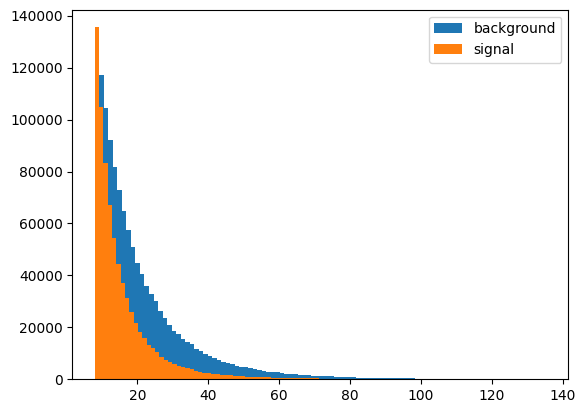

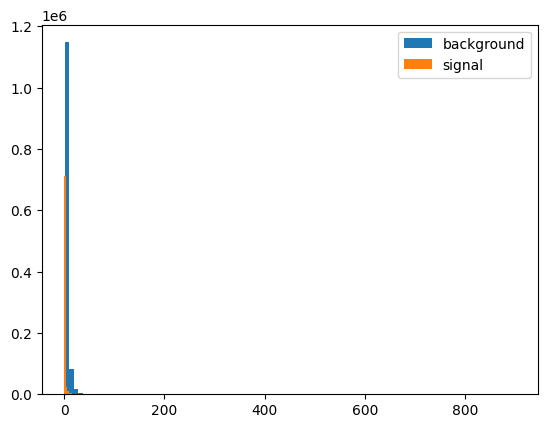

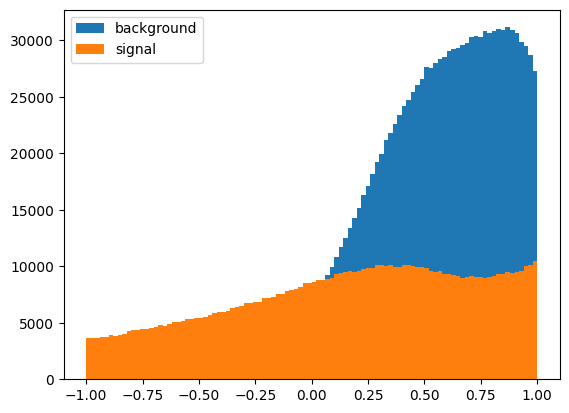

In [27]:
plt.figure()
hists = plt.hist(X_train1["DMesons_pt"], bins = 100, label = "background")
hists = plt.hist(X_train2["DMesons_pt"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
hists1 = plt.hist(X_train1["DMesons_fitOutput__Lxy"], bins = 100, label = "background")
hists1 = plt.hist(X_train2["DMesons_fitOutput__Lxy"], bins = 100, label = "signal")
plt.legend()
plt.show()

plt.figure()
hists2 = plt.hist(X_train1["DMesons_costhetastar"], bins = 100, label = "background")
hists2 = plt.hist(X_train2["DMesons_costhetastar"], bins = 100, label = "signal")
plt.legend()
plt.show()

In [28]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 64,
        "activation_1": "relu",
        "dropout": 0.5,
        "layer_2": 32,
        "activation_2": "relu",
        "dropout": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)

config = wandb.config

In [29]:
#model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [30]:
#Compile
model.compile(optimizer='adam', loss='binary_crossentropy')

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')
# checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True, verbose=1)
# tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
#Train
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

#supress the errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

Epoch 1/50
62881/62900 [============================>.] - ETA: 0s - loss: 0.1936

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 107s 2ms/step - loss: 0.1936 - val_loss: 0.1635
Epoch 2/50
62900/62900 [==============================] - 105s 2ms/step - loss: 0.1718 - val_loss: 0.1665
Epoch 3/50
62890/62900 [============================>.] - ETA: 0s - loss: 0.1691

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 106s 2ms/step - loss: 0.1691 - val_loss: 0.1610
Epoch 4/50
62900/62900 [==============================] - 105s 2ms/step - loss: 0.1675 - val_loss: 0.1619
Epoch 5/50
62876/62900 [============================>.] - ETA: 0s - loss: 0.1663

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 106s 2ms/step - loss: 0.1663 - val_loss: 0.1591
Epoch 6/50
62900/62900 [==============================] - 106s 2ms/step - loss: 0.1657 - val_loss: 0.1595
Epoch 7/50
62900/62900 [==============================] - 104s 2ms/step - loss: 0.1650 - val_loss: 0.1592
Epoch 8/50
62886/62900 [============================>.] - ETA: 0s - loss: 0.1644

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 106s 2ms/step - loss: 0.1644 - val_loss: 0.1581
Epoch 9/50
62882/62900 [============================>.] - ETA: 0s - loss: 0.1639

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 105s 2ms/step - loss: 0.1639 - val_loss: 0.1561
Epoch 10/50
62900/62900 [==============================] - 106s 2ms/step - loss: 0.1635 - val_loss: 0.1574
Epoch 11/50
62890/62900 [============================>.] - ETA: 0s - loss: 0.1633

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 105s 2ms/step - loss: 0.1633 - val_loss: 0.1558
Epoch 12/50
62874/62900 [============================>.] - ETA: 0s - loss: 0.1631

INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230404_141019-p3gxwu5d/files/model-best)... Done. 0.0s


62900/62900 [==============================] - 105s 2ms/step - loss: 0.1632 - val_loss: 0.1551
Epoch 13/50
62900/62900 [==============================] - 105s 2ms/step - loss: 0.1628 - val_loss: 0.1558
Epoch 14/50
62900/62900 [==============================] - 106s 2ms/step - loss: 0.1628 - val_loss: 0.1591
Epoch 15/50
62900/62900 [==============================] - 105s 2ms/step - loss: 0.1627 - val_loss: 0.1565
Epoch 15: early stopping
  614/15725 [>.............................] - ETA: 16s - loss: 0.1509

KeyboardInterrupt: 

2023-04-04 14:12:22.055330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-04 14:12:22.068970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-04-04 14:12:22.221666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-04-04 14:12:22

In [31]:
wandb.finish()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▆█▅▅▃▄▃▃▂▂▁▁▁▃▂
best_epoch,11
best_val_loss,0.15514
epoch,14
loss,0.16266
val_loss,0.1565


------------------------------------------ Finished training, now analyze ------------------------------------------

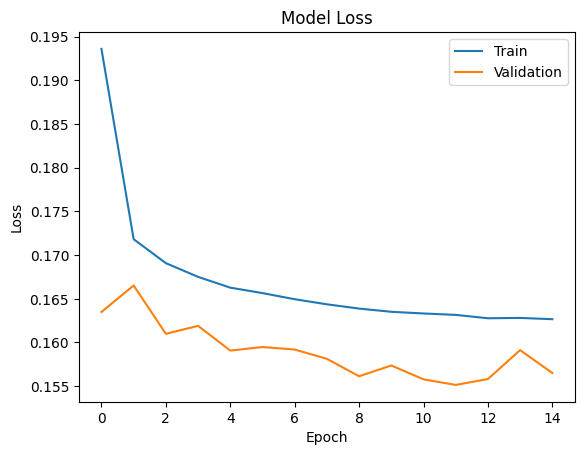

In [32]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [33]:
predictions = model.predict(X_test)
predictions[:10]

15725/15725 [==============================] - 15s 969us/step


array([[1.        ],
       [0.982068  ],
       [1.        ],
       [0.04390786],
       [1.        ],
       [0.04619064],
       [0.04390786],
       [0.09623186],
       [0.17891212],
       [1.        ]], dtype=float32)

In [44]:
predictions1 = model.predict(X_test1)
predictions1[:10]

9792/9792 [==============================] - 9s 964us/step


array([[0.05557281],
       [0.08035788],
       [0.04390786],
       [0.04390786],
       [0.04968708],
       [0.04390786],
       [0.04616571],
       [0.04390786],
       [0.04390786],
       [0.05926038]], dtype=float32)

In [45]:
predictions2 = model.predict(X_test2)
predictions2[:10]

5934/5934 [==============================] - 6s 986us/step


array([[1.       ],
       [1.       ],
       [0.5278276],
       [1.       ],
       [0.9995366],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ],
       [1.       ]], dtype=float32)

In [53]:
predictions_list = []
D_count = 0
Lambda_count = 0
unclear = 0
for pred in predictions:
    if float(pred) > 0.5:
        predictions_list.append(int(1))
        Lambda_count+=1
    elif float(pred) < 0.5:
        predictions_list.append(int(0))
        D_count+=1
    else:
        unclear+=1
        
print("$D^+$ Count: {}".format(D_count))
print("$\Lambda_C^+ Count: {}".format(Lambda_count))
print("Unknown Particle Count: {}".format(unclear))
np.shape(predictions)

$D^+$ Count: 337287
$\Lambda_C^+ Count: 165912
Unknown Particle Count: 0


(503199, 1)

In [55]:
accuracy = np.mean(predictions_list == y_test)
print("Accuracy: {:.2%}".format(accuracy))

y_test

Accuracy: 95.12%


1389563    1
1338077    0
1768909    1
1668714    0
46030      1
          ..
818454     1
1789196    0
1318873    1
1487220    1
2315328    0
Name: DMesons_pdgId, Length: 503199, dtype: int64

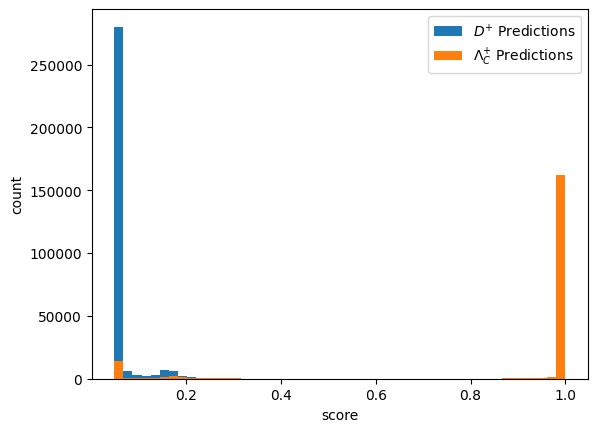

In [82]:
hist = plt.hist(predictions1, bins = 50, label = "$D^{+}$ Predictions")
hist2 = plt.hist(predictions2, bins = 50, label = "$\Lambda_C^{+}$ Predictions")
plt.xlabel("score")
plt.ylabel("count")
plt.legend()
plt.show()